In [1]:
import numpy as np
import pandas as pd

import scanpy.api as sc
sc.settings.verbosity = 3                # verbosity = 3: errors, warnings, info, hints
sc.settings.set_figure_params(dpi=70)    # dots (pixels) per inch determine size of inline figures
sc.logging.print_version_and_date()

from matplotlib import pyplot as plt
import matplotlib.colors as mcol
cm1 = mcol.LinearSegmentedColormap.from_list("BuRd",["b","r"])

/home/jpoles1/.local/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Running Scanpy version 0.2.8 on 2017-10-31 12:38.


## Loading Data

In [2]:
data_folder = "data/progression/"
filename_data = data_folder+"matrix.mtx"
filename_genes = data_folder+"genes.tsv"
filename_barcodes = data_folder+"barcodes.tsv"
adata = sc.read(filename_data, cache=True).transpose()
adata.var_names = np.genfromtxt(filename_genes, dtype=str)[:, 1]
adata.smp_names = np.genfromtxt(filename_barcodes, dtype=str)

reading file ./write/data/progression/matrix.h5


## Preprocessing

In [3]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [4]:
mito_genes = np.array([name for name in adata.var_names if name.startswith('mt-')])
# for each cell compute fraction of counts in mito genes vs. all genes
adata.smp['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as sample annotation to adata
adata.smp['n_counts'] = np.sum(adata.X, axis=1).A1

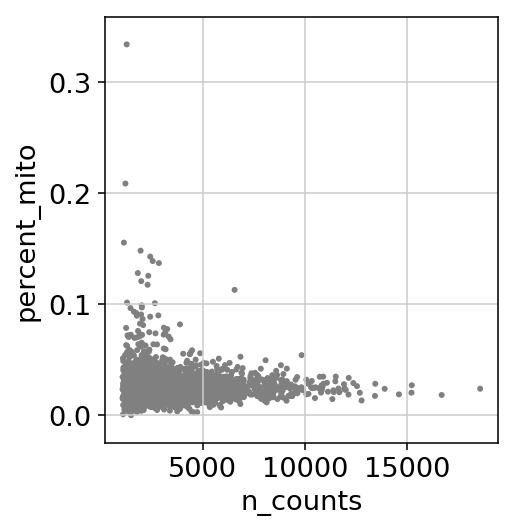

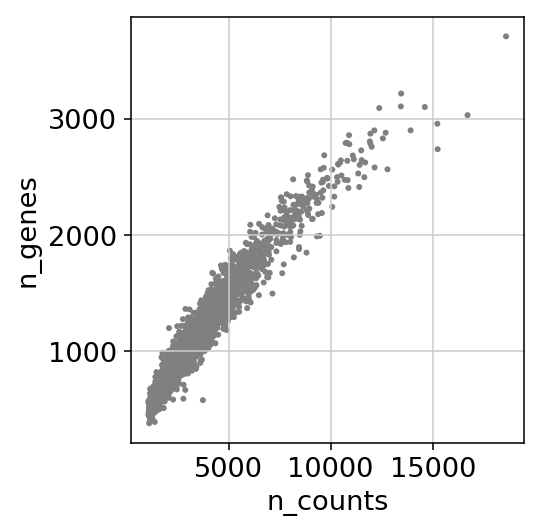

In [5]:
axs = sc.pl.scatter(adata, x='n_counts', y='percent_mito')
axs = sc.pl.scatter(adata, x='n_counts', y='n_genes')

In [6]:
print(adata.n_smps)
adata[adata.smp['n_genes'] < 2500, :]
adata = adata[adata.smp['percent_mito'] < 0.05, :]
print(adata.n_smps)

3157
3060


In [7]:
sc.write(data_folder+'pbmc3k_filtered_raw_log', sc.pp.log1p(adata, copy=True))

writing ./write/data/progression/pbmc3k_filtered_raw_log.h5


normalizing by total count per cell
    finished (0:00:00.038) normalized adata.X and added
    "n_counts", counts per cell before normalization (adata.smp)
filter highly varying genes by dispersion and mean (0:00:00.174)
--> set `n_top_genes` to simply select top-scoring genes instead


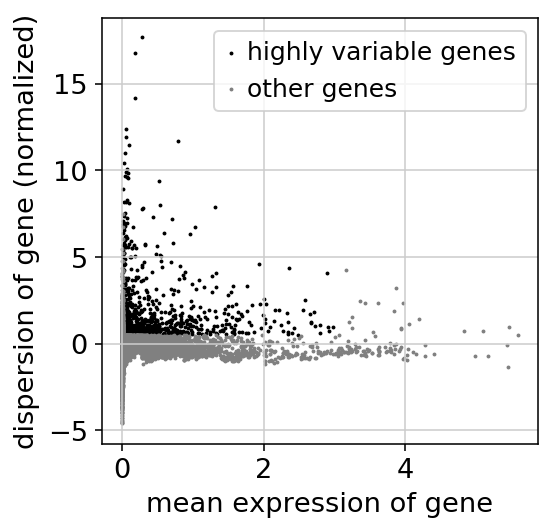

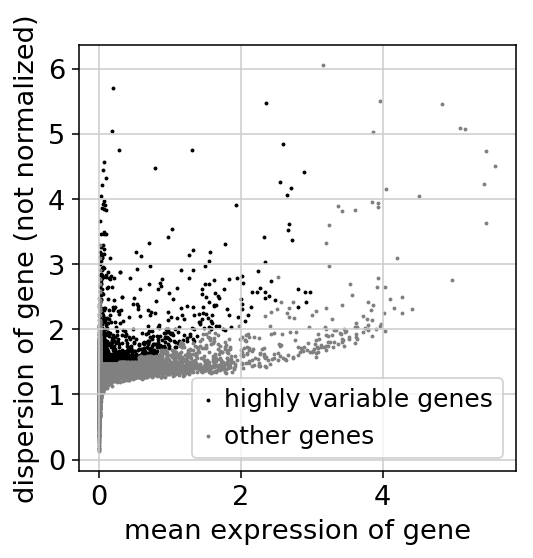

In [8]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
filter_result = sc.pp.filter_genes_dispersion(
    adata.X, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.filter_genes_dispersion(filter_result)

In [9]:
adata = adata[:, filter_result.gene_subset]
sc.pp.log1p(adata)

In [10]:
adata_corrected = sc.pp.regress_out(adata, ['n_counts', 'percent_mito'], copy=True)

HBox(children=(IntProgress(value=0, max=3), HTML(value='')))

In [11]:
sc.pp.scale(adata_corrected, max_value=10)

In [12]:
sc.write(data_folder+'pbmc3k_corrected', adata_corrected)

writing ./write/data/progression/pbmc3k_corrected.h5


## Dimensionality Reduction

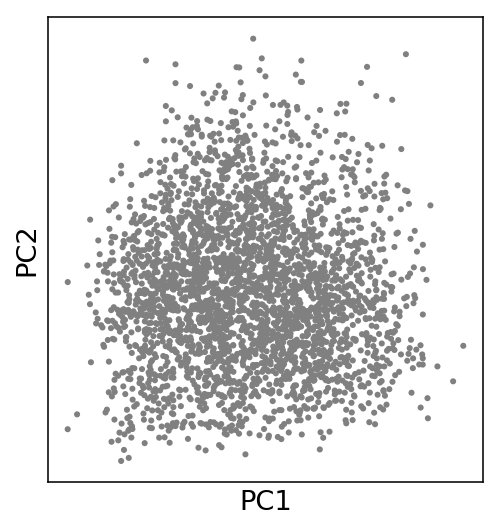

In [13]:
sc.tl.pca(adata_corrected)
ax = sc.pl.pca_scatter(adata_corrected, right_margin=0.2)

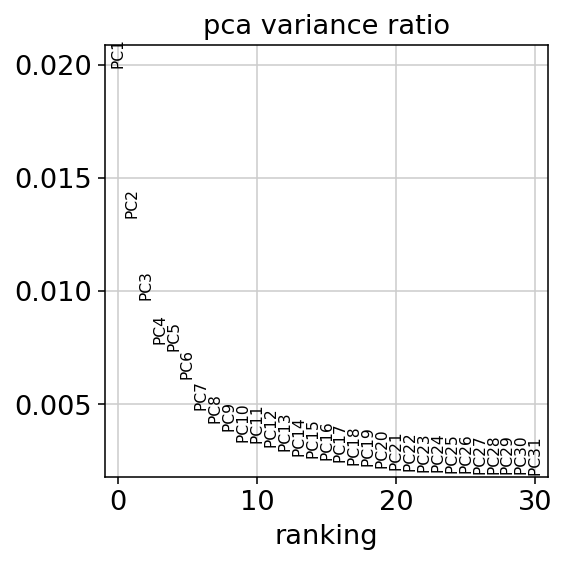

In [14]:
sc.pl.pca_variance_ratio(adata_corrected, log=0)

In [15]:
adata_corrected = sc.read(data_folder+'pbmc3k_corrected')

reading file ./write/data/progression/pbmc3k_corrected.h5


In [16]:
sc.tl.tsne(adata_corrected, n_pcs=15)

computing tSNE
    preprocess using PCA with 15 PCs
--> avoid this by setting n_pcs = 0
    using 15 principal components
    using the "MulticoreTSNE" package by Ulyanov (2017)
    finished (0:00:06.473) and added
    "X_tsne", tSNE coordinates (adata.smp)


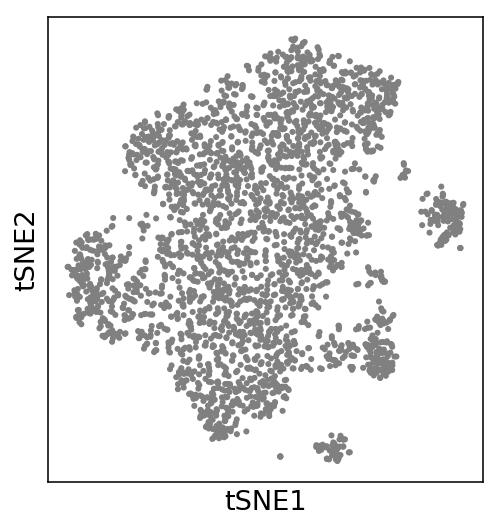

In [17]:
ax = sc.pl.tsne(adata_corrected)

## Clustering

In [18]:
sc.tl.louvain(adata_corrected, flavor="igraph", recompute_graph=True, n_pcs=15)

running Louvain clustering
    using "X_pca" for building graph
    computing data graph with n_neighbors = 30 
    computing spectral decomposition ("diffmap") with 15 components
    eigenvalues of transition matrix
    [ 1.            0.9528958201  0.9417973161  0.9346754551  0.9228753448
      0.9151253104  0.8921883106  0.8787964582  0.8656893373  0.8216817379
      0.8023656011  0.7938104272  0.7788447738  0.7720831037  0.7626338005]
    finished (0:00:01.803) and found 10 clusters, added
    "louvain_groups", the cluster labels (adata.smp)
    "louvain_groups_order", the unique cluster labels (adata.add)


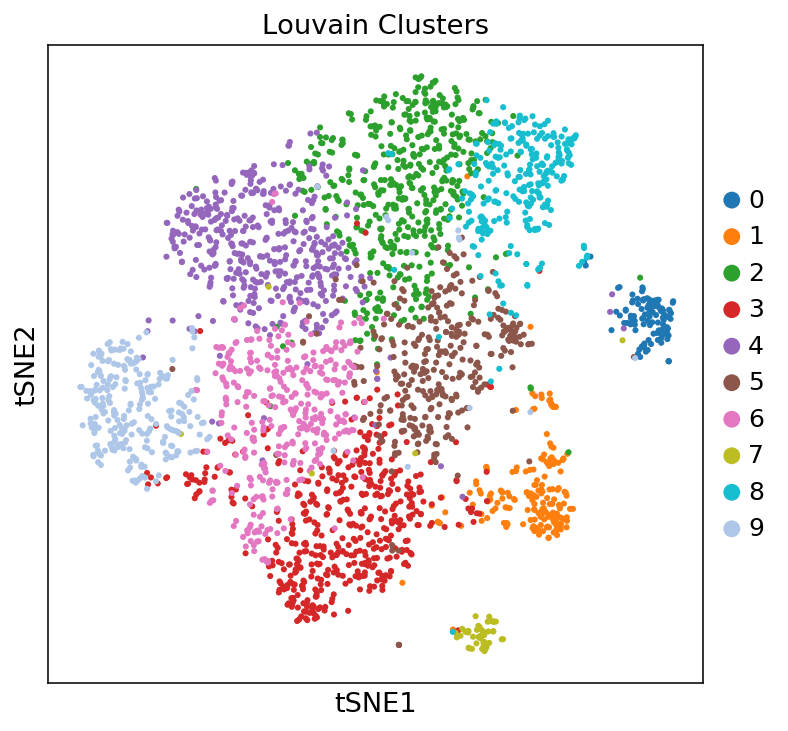

In [19]:
plt.figure(figsize=[6,6])
ax = plt.subplot(111)
sc.pl.tsne(adata_corrected, color='louvain_groups', title="Louvain Clusters", ax=ax, show=0)
plt.show()

In [20]:
sc.write(data_folder+'pbmc3k_corrected', adata_corrected)

writing ./write/data/progression/pbmc3k_corrected.h5


reading file ./write/data/progression/pbmc3k_corrected.h5
reading file ./write/data/progression/pbmc3k_filtered_raw_log.h5
find differentially expressed genes
... consider "louvain_groups": ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9'] with sample numbers [103 187 518 499 453 344 367  53 268 268]
    finished (0:00:01.454) and added
    "rank_genes_groups_gene_names", np.recarray to be indexed by the `groups` (adata.add)
    "rank_genes_groups_gene_zscores", the scores (adata.add)
    "rank_genes_...", distributions of top-ranked genes (adata.smp)


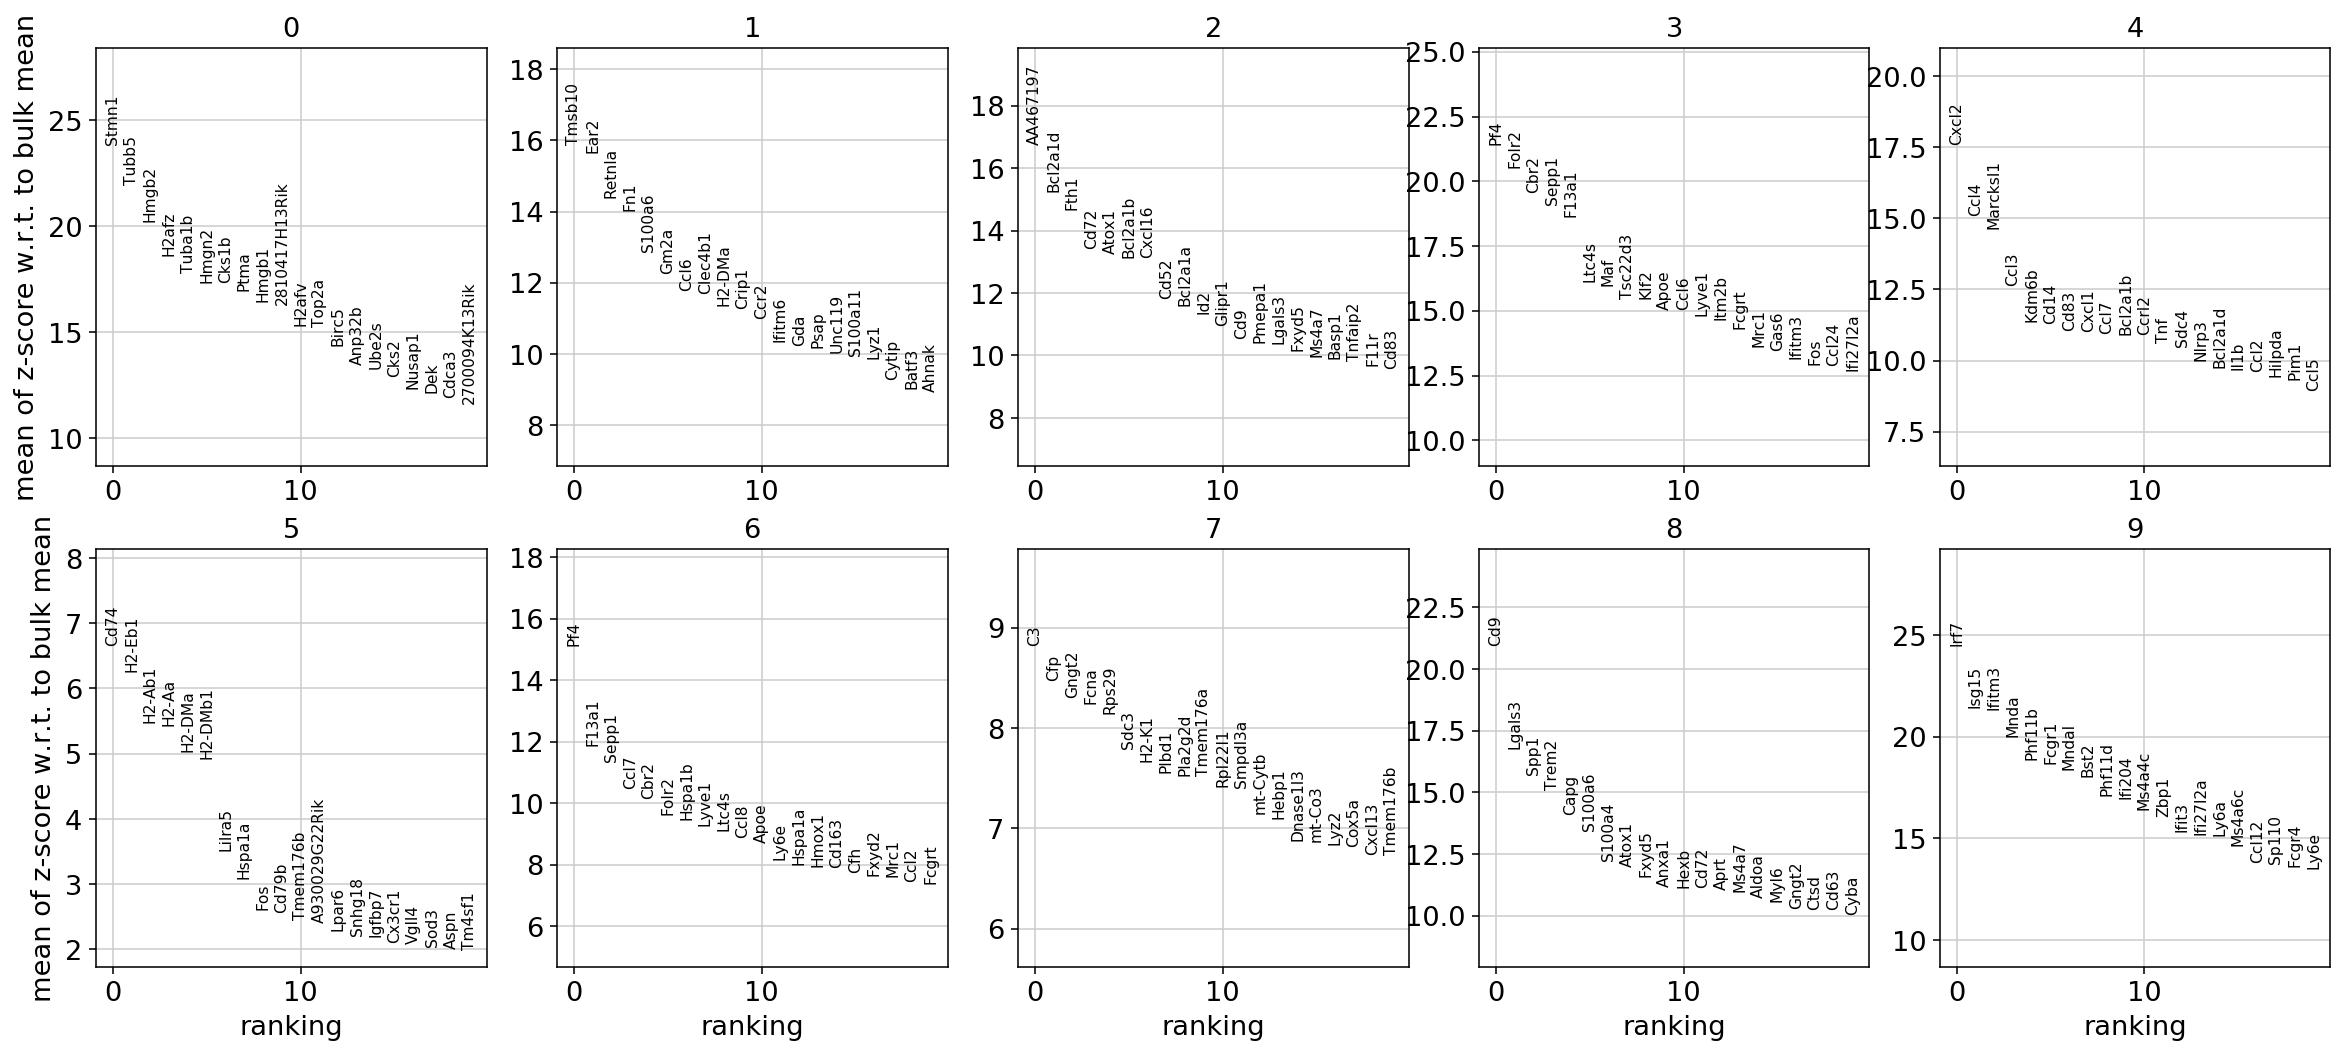

In [21]:
adata_corrected = sc.read(data_folder+'pbmc3k_corrected')
adata_raw = sc.read(data_folder+'pbmc3k_filtered_raw_log')
adata_raw.smp['louvain_groups'] = adata_corrected.smp['louvain_groups']
adata_raw.smp["X_tsne"] = adata_corrected.smp["X_tsne"]
sc.tl.rank_genes_groups(adata_raw, 'louvain_groups')
sc.pl.rank_genes_groups(adata_raw, n_genes=20)

In [22]:
diff_genes = sc.tl.rank_genes_groups(adata_raw, 'louvain_groups', copy=1, n_genes=400)
diff_genes_scores = pd.DataFrame(diff_genes.add["rank_genes_groups_gene_scores"])
diff_genes = pd.DataFrame(diff_genes.add["rank_genes_groups_gene_names"])

find differentially expressed genes
... consider "louvain_groups": ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9'] with sample numbers [103 187 518 499 453 344 367  53 268 268]
    finished (0:00:01.323) and added
    "rank_genes_groups_gene_names", np.recarray to be indexed by the `groups` (adata.add)
    "rank_genes_groups_gene_zscores", the scores (adata.add)
    "rank_genes_...", distributions of top-ranked genes (adata.smp)


In [23]:
def top_clust_genes(clust_num, top_n=5):
    print("Plotting Heatmaps for top "+str(top_n)+" genes in cluster #"+str(clust_num))
    for gene_name in np.array(diff_genes.iloc[:top_n, clust_num]):
        sc.pl.tsne(adata_raw, color=gene_name, title=gene_name+" Expression", color_map=cm1)

Plotting Heatmaps for top 10 genes in cluster #0


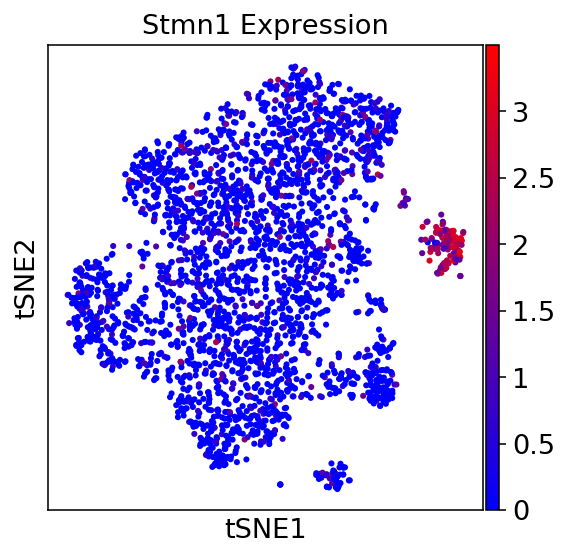

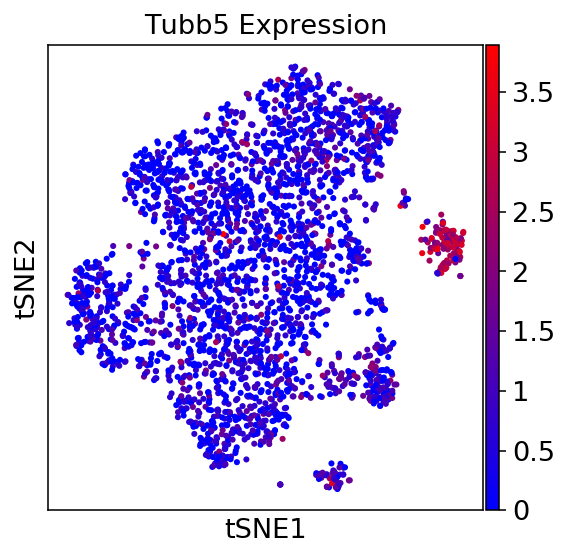

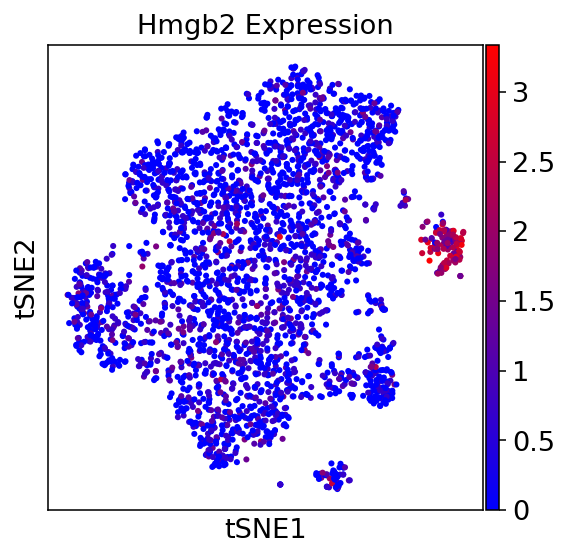

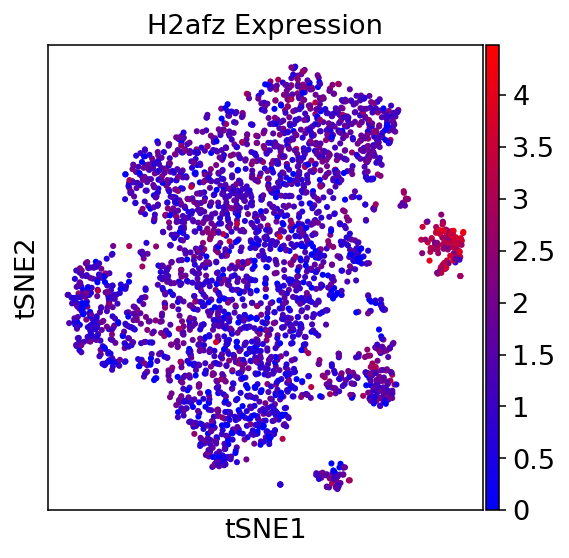

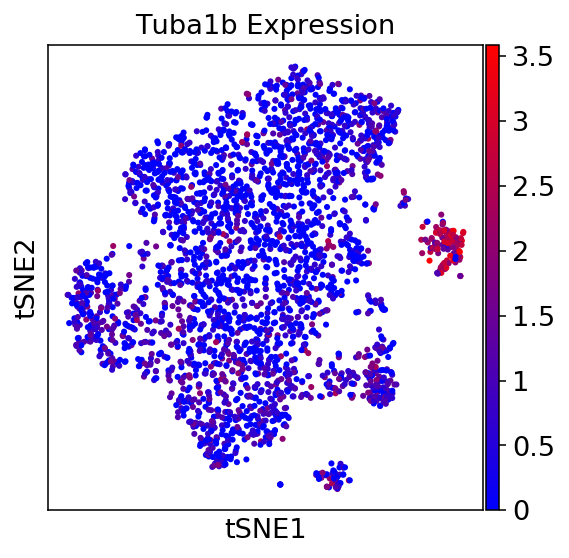

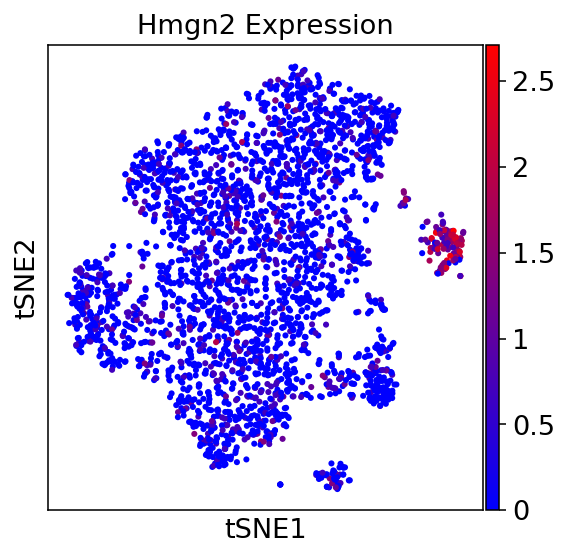

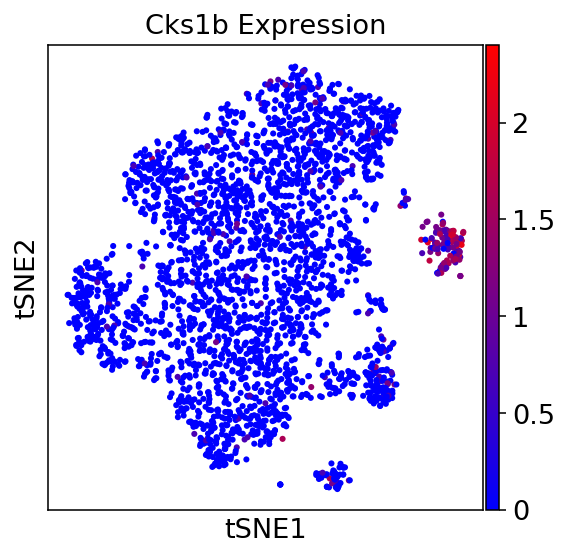

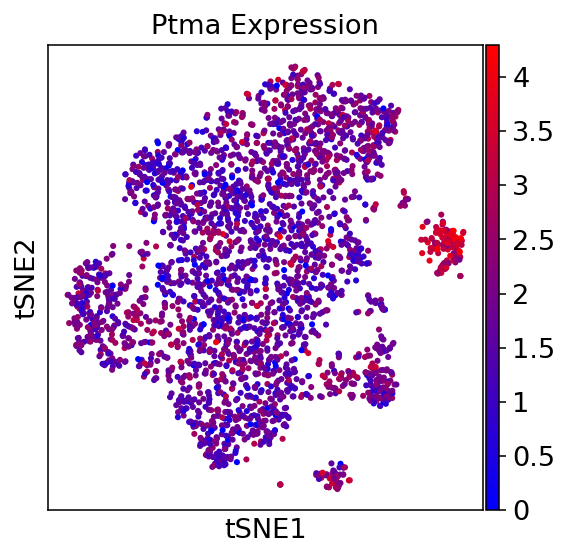

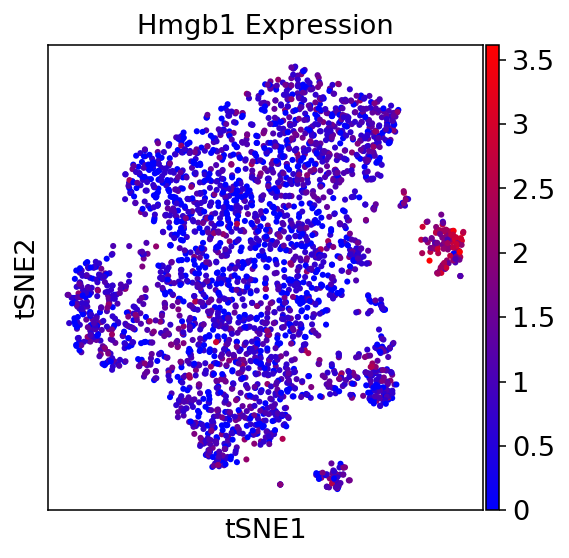

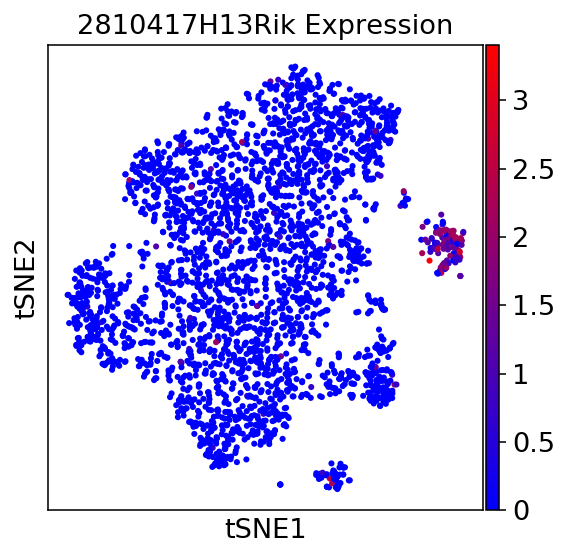

Plotting Heatmaps for top 10 genes in cluster #1


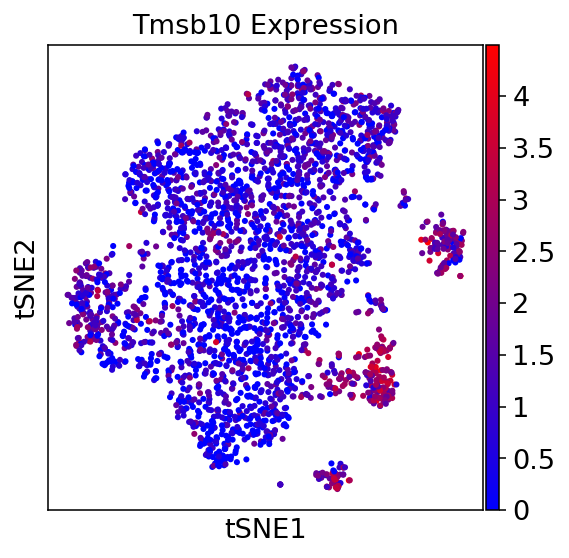

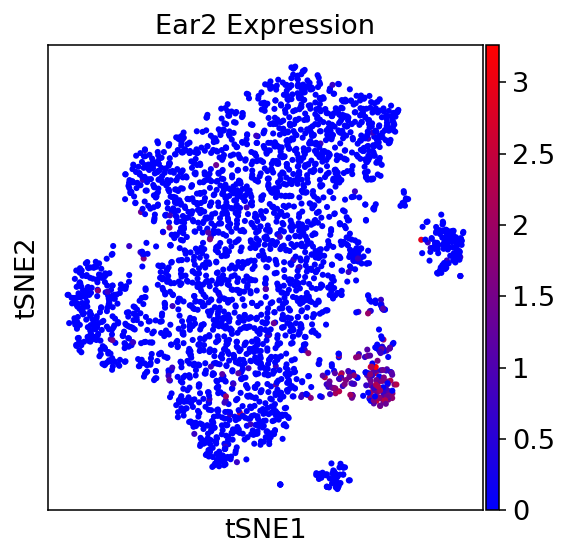

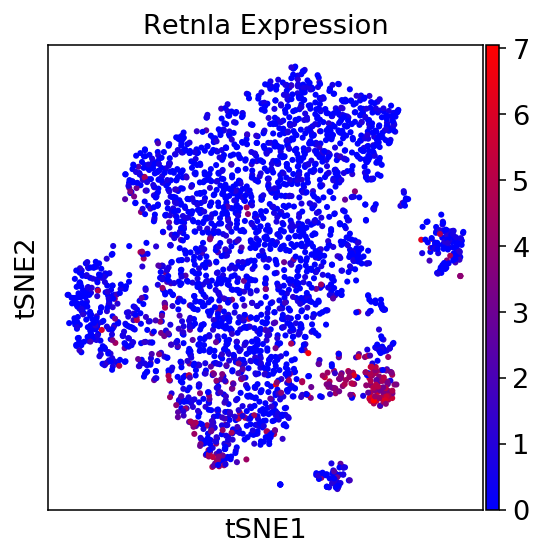

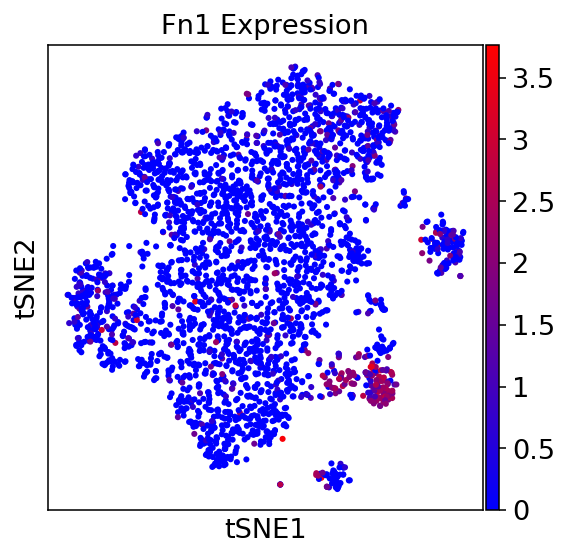

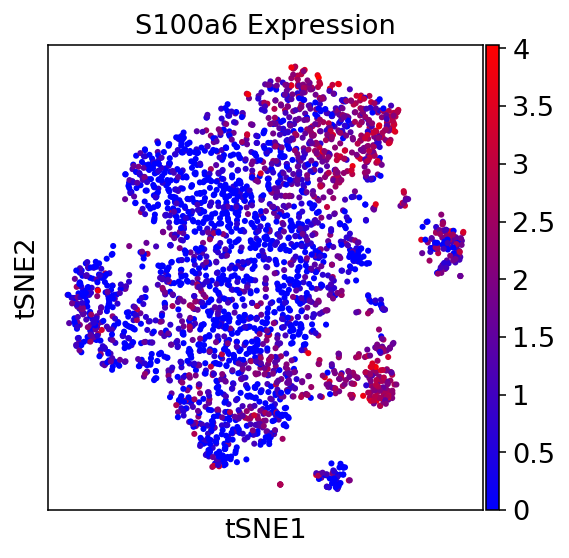

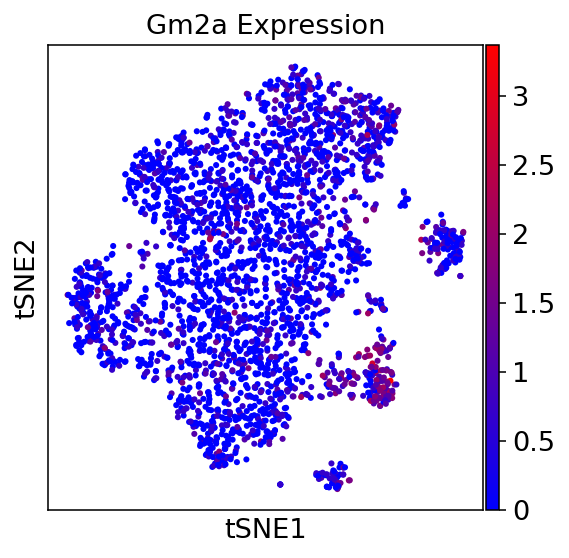

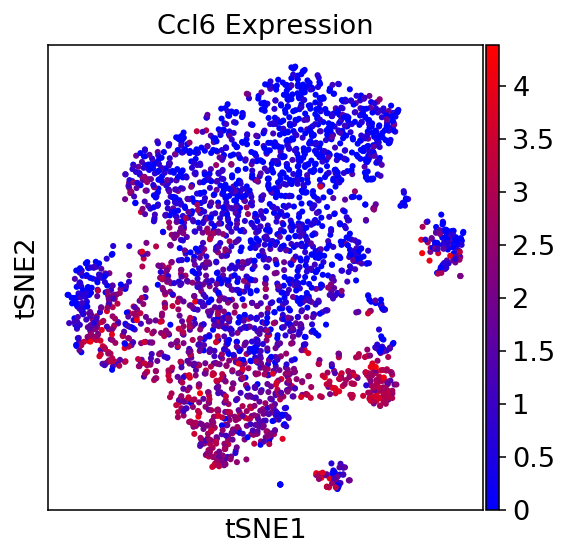

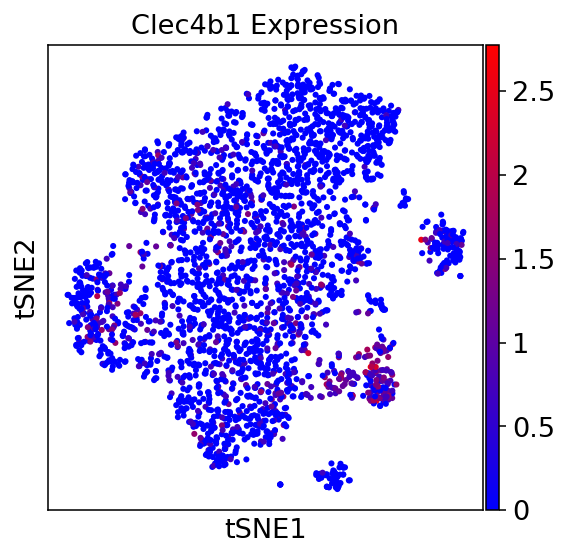

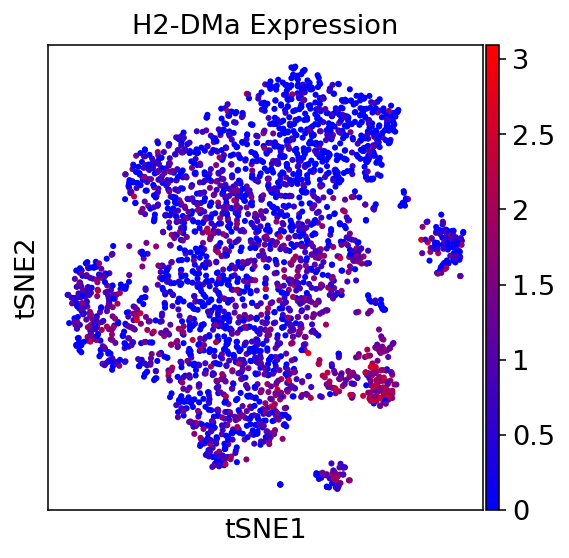

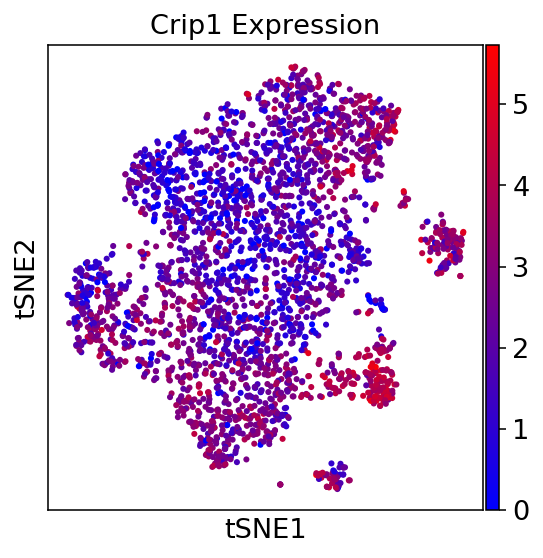

Plotting Heatmaps for top 10 genes in cluster #9


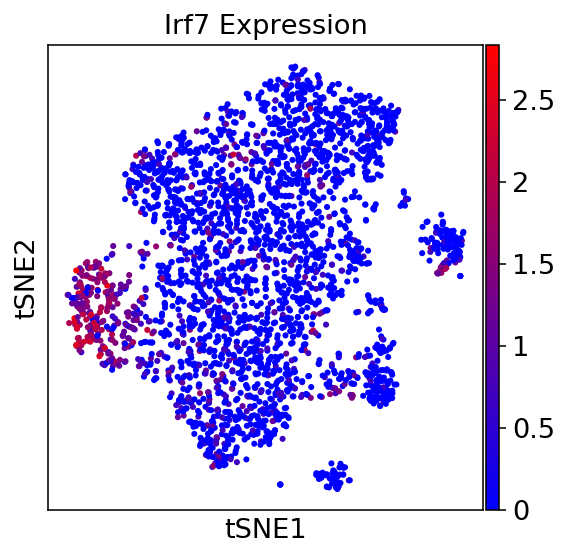

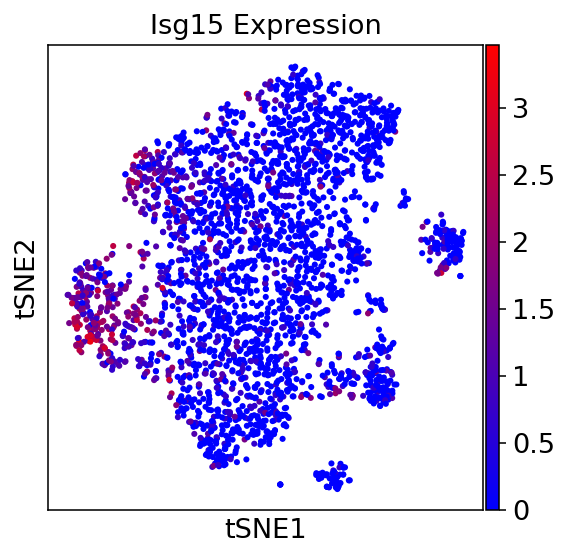

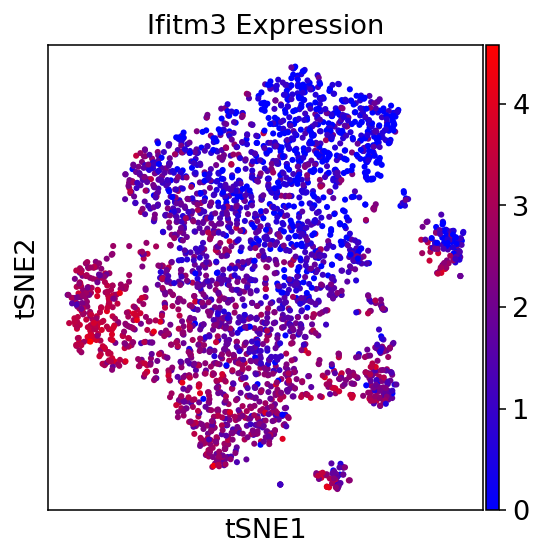

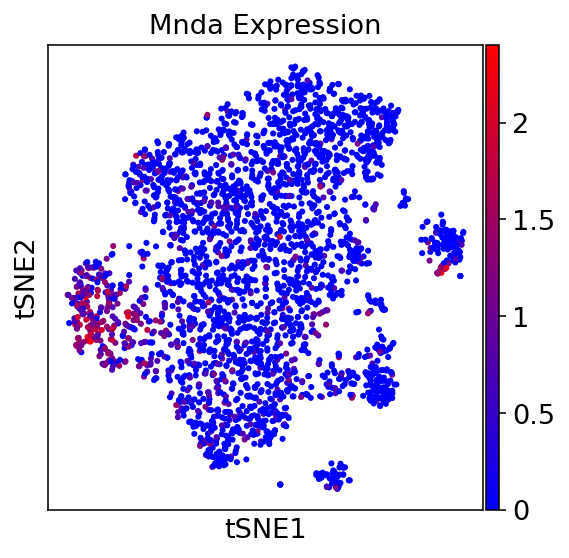

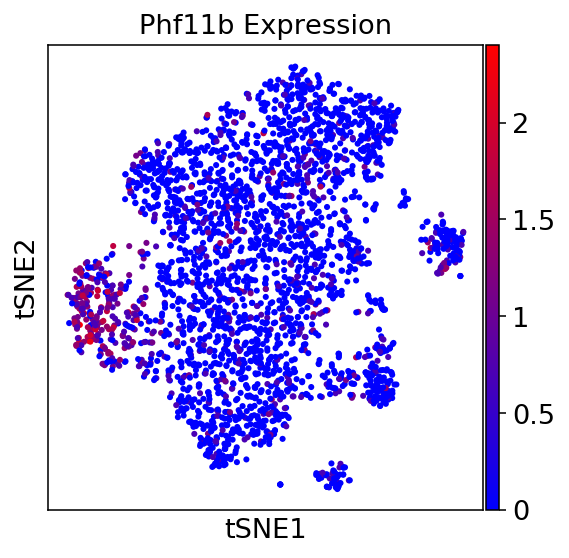

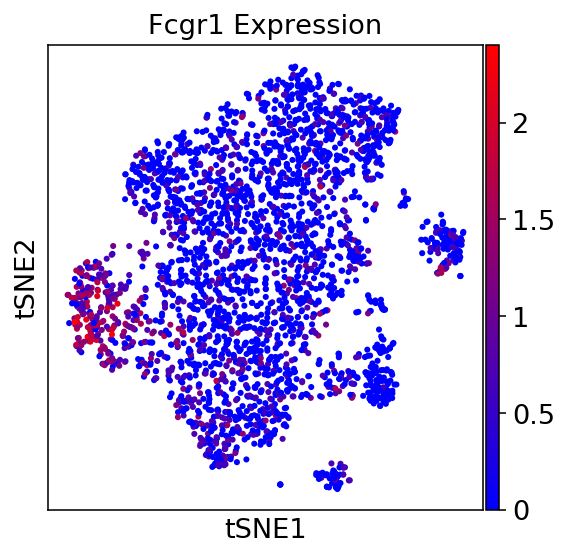

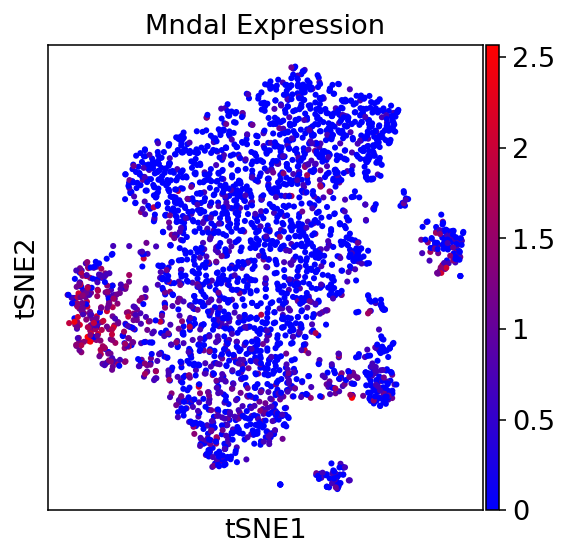

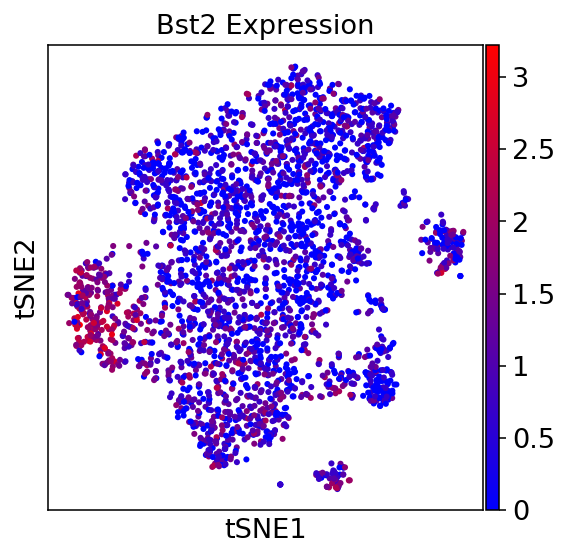

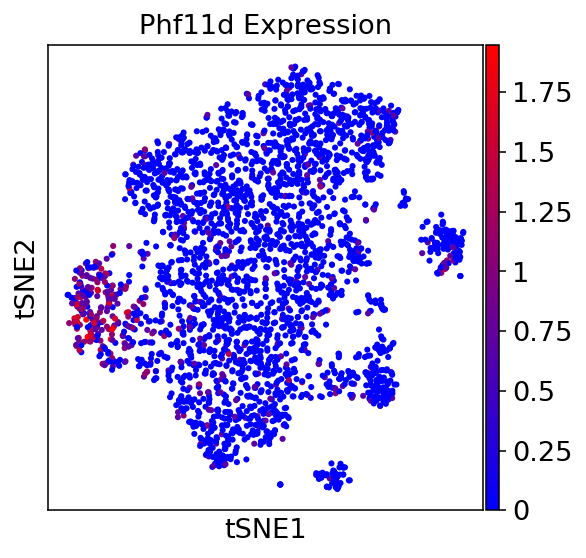

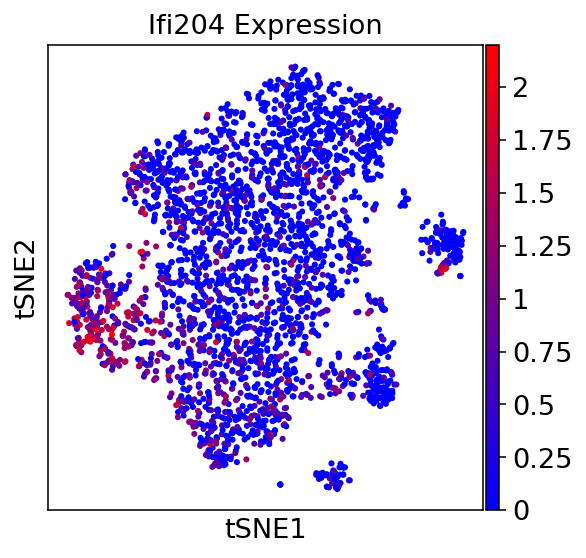

Plotting Heatmaps for top 10 genes in cluster #7


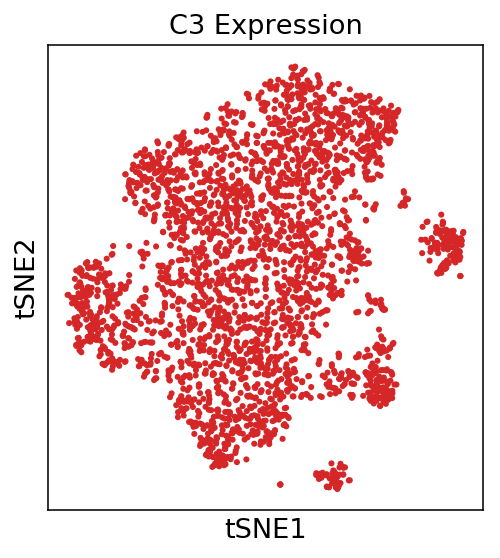

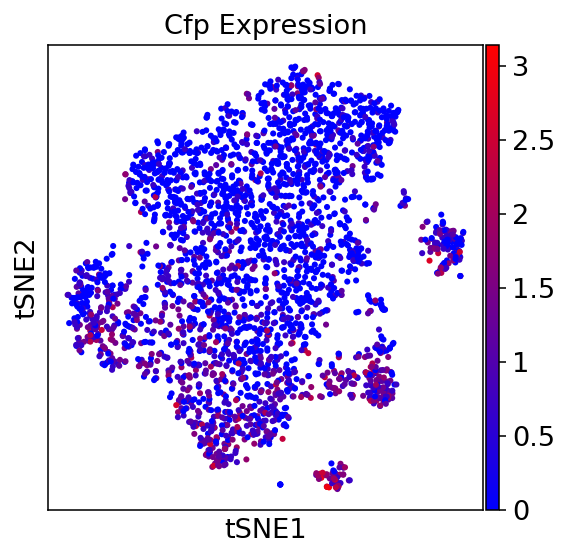

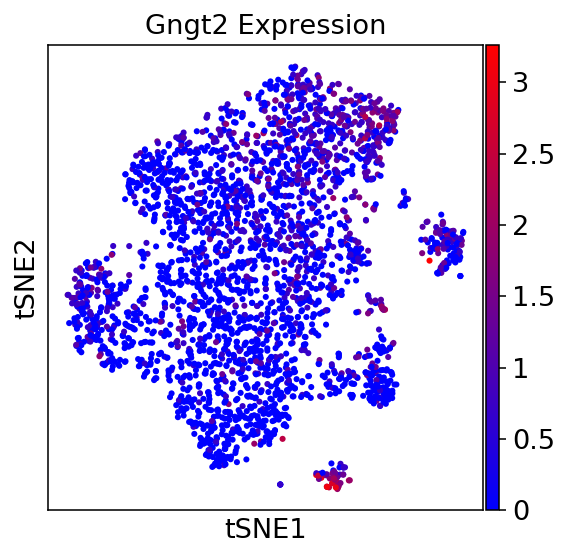

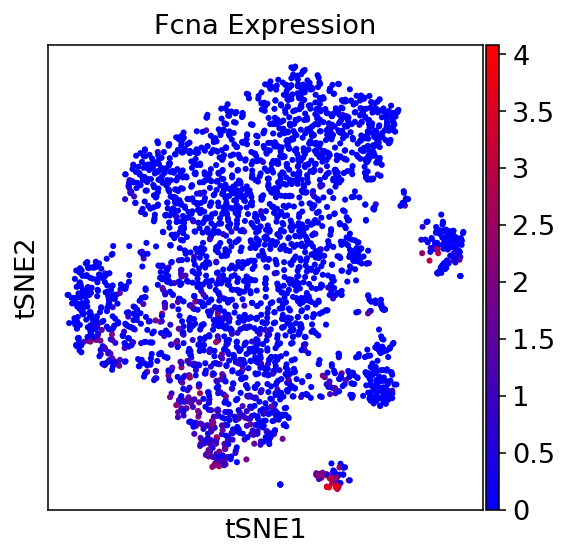

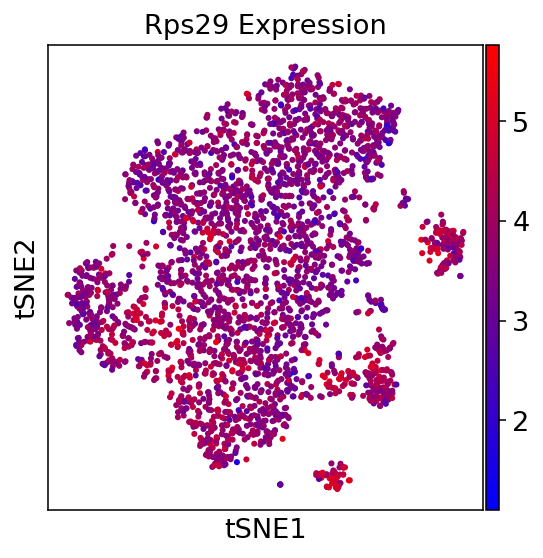

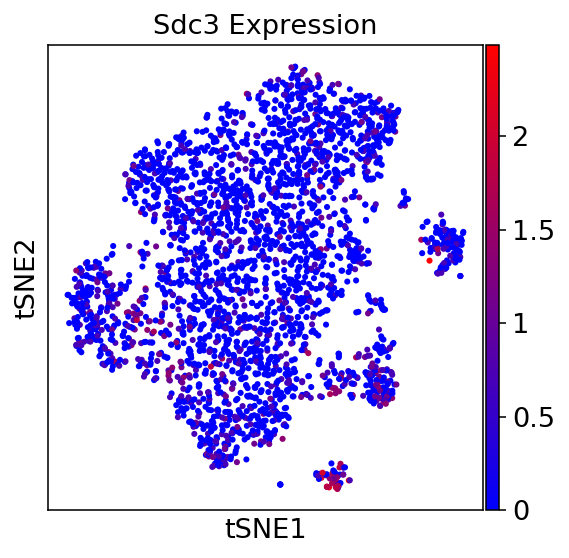

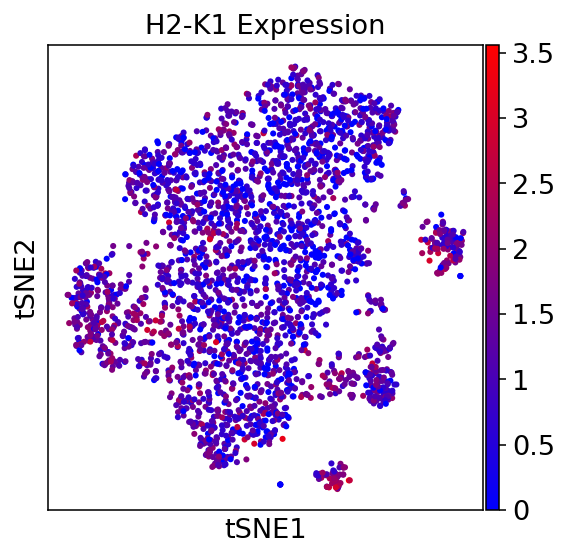

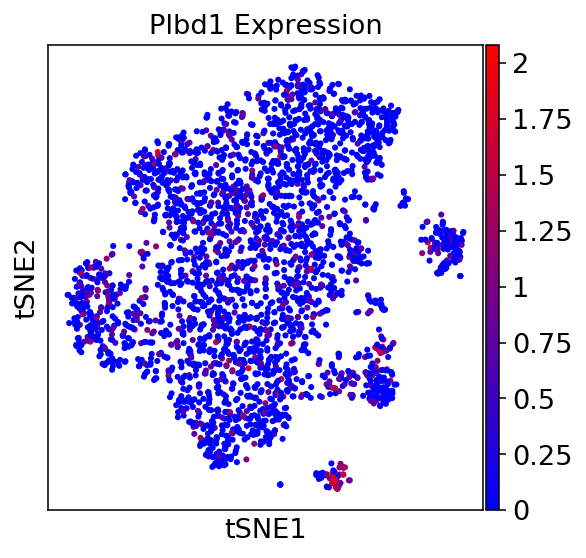

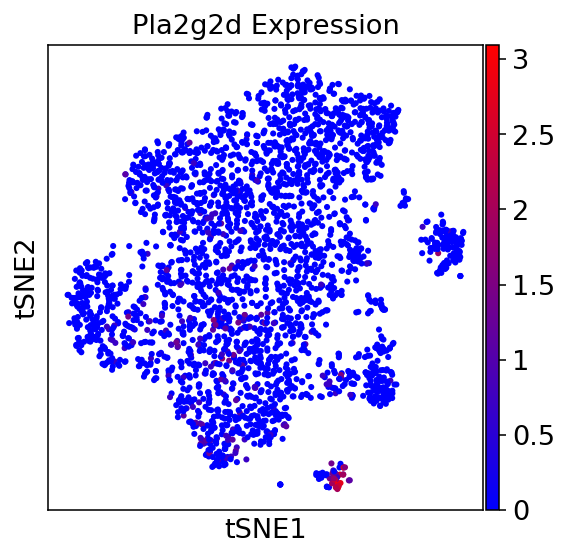

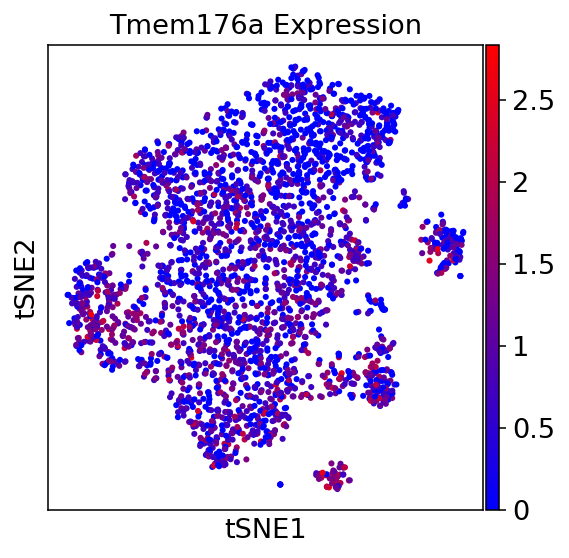

In [24]:
top_clust_genes(0, 10)
top_clust_genes(1, 10)
top_clust_genes(9, 10)
top_clust_genes(7, 10)

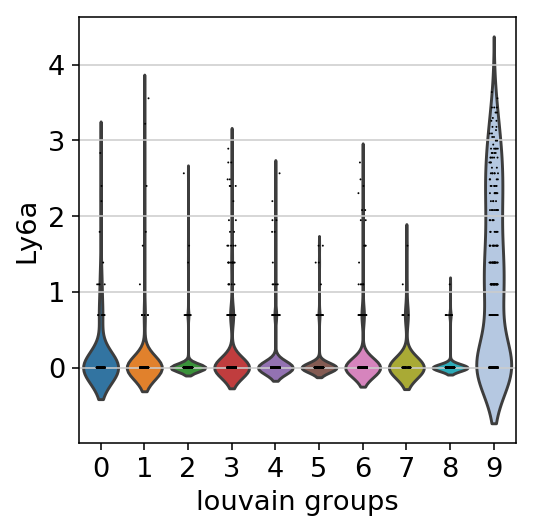

In [25]:
ax = sc.pl.violin(adata_raw, 'Ly6a', group_by='louvain_groups')

## Gene Ontology Enrichment

In [26]:
import gzip
import Bio.UniProt.GOA as GOA
from goatools.base import download_go_basic_obo
from goatools import obo_parser, GOEnrichmentStudy
from goatools.godag_plot import plot_gos, plot_results, plot_goid2goobj
obo_fname = download_go_basic_obo()
go_db = obo_parser.GODag(obo_fname)
# File is a gunzip file, so we need to open it in this way
with gzip.open("goa_mouse.gaf.gz", 'rt') as arab_gaf_fp:
    arab_funcs = {}  # Initialise the dictionary of functions
    # Iterate on each function using Bio.UniProt.GOA library.
    for entry in GOA.gafiterator(arab_gaf_fp):
        uniprot_id = entry.pop('DB_Object_ID')
        arab_funcs[uniprot_id] = entry
gene_frame = pd.DataFrame(arab_funcs).T

  EXISTS: go-basic.obo
load obo file go-basic.obo
go-basic.obo: fmt(1.2) rel(2017-10-25) 47,009 GO Terms


In [27]:
def top_clust_ontologies(clust_num, top_n_ontologies=10, top_n_genes=200):
    print("Plotting top "+str(top_n_ontologies)+" gene ontologies in cluster #"+str(clust_num)+" using the top "+str(top_n_genes)+" genes")
    go_frame = pd.DataFrame([diff_genes.iloc[:top_n_genes, clust_num], diff_genes_scores.iloc[:top_n_genes, clust_num]]).T
    go_frame.columns = ["GeneName", "GeneScore"]
    go_frame = go_frame.merge(gene_frame[["DB_Object_Symbol", "GO_ID"]], how="left", left_on="GeneName", right_on="DB_Object_Symbol")
    go_frame_sparse = go_frame.dropna()
    missing_annot = len(go_frame.index) - len(go_frame_sparse.index)
    if missing_annot > 0:
        print("Missing annotations for "+str(missing_annot)+" of "+str(len(go_frame.index))+" genes")
    go_frame_sparse = go_frame_sparse.assign(GO_Name= [go_db[x].name for x in go_frame_sparse["GO_ID"]])
    go_scores = go_frame_sparse.groupby("GO_Name")["GeneScore"].sum().sort_values()[-top_n_ontologies:]
    go_scores.plot.barh()
    plt.title("Enriched Ontologies in Cluster #"+str(clust_num))
    plt.show()
    print("\n"+"-"*100+"\n")
    return go_frame

Plotting top 10 gene ontologies in cluster #0 using the top 100 genes
Missing annotations for 8 of 100 genes


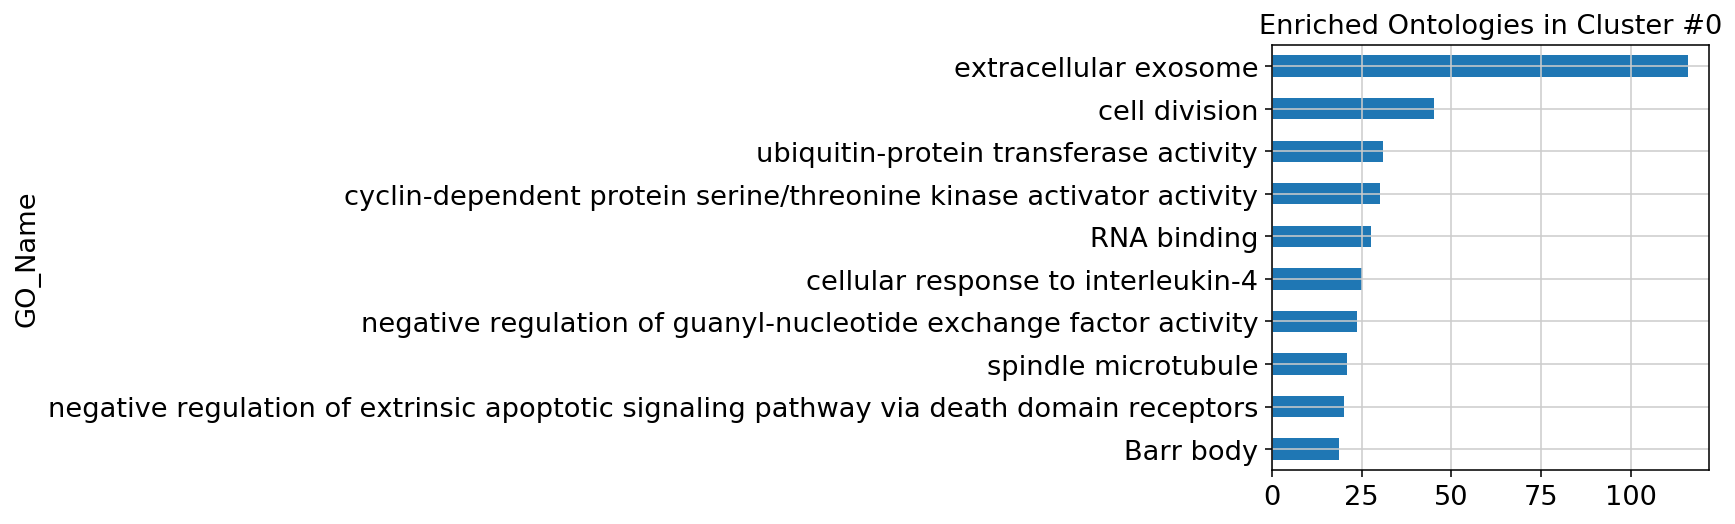


----------------------------------------------------------------------------------------------------

Plotting top 10 gene ontologies in cluster #1 using the top 100 genes
Missing annotations for 9 of 100 genes


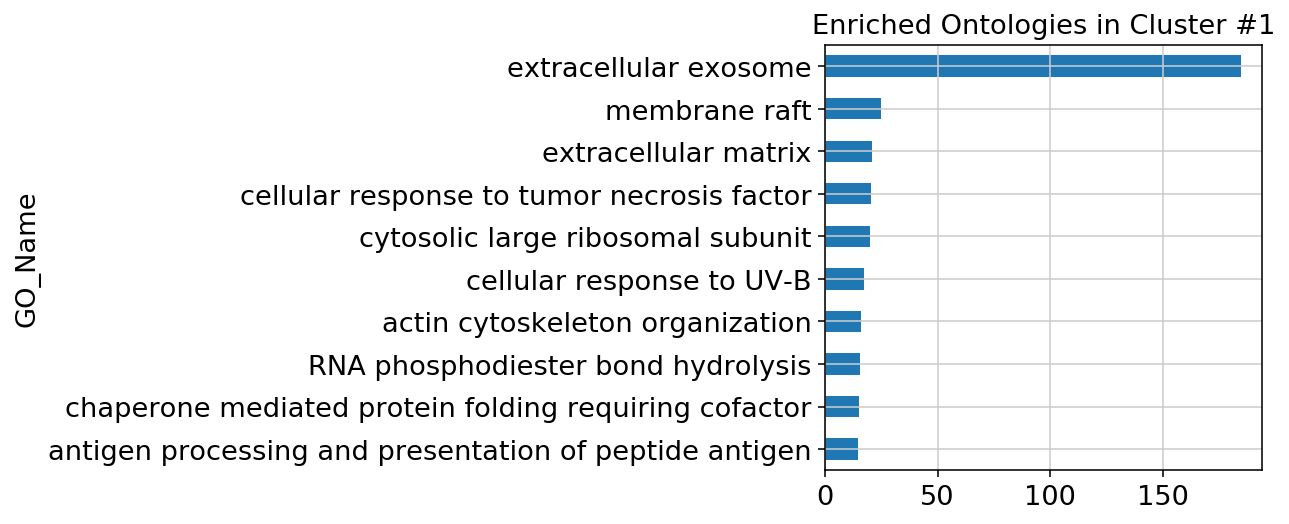


----------------------------------------------------------------------------------------------------

Plotting top 10 gene ontologies in cluster #9 using the top 100 genes
Missing annotations for 8 of 100 genes


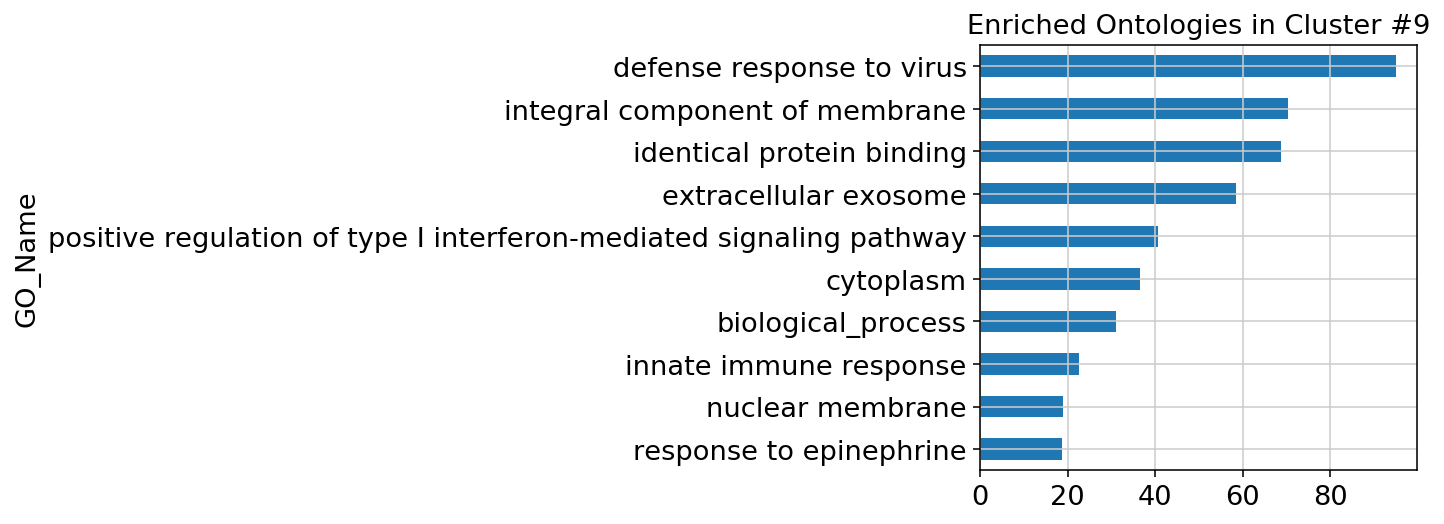


----------------------------------------------------------------------------------------------------

Plotting top 10 gene ontologies in cluster #2 using the top 100 genes
Missing annotations for 6 of 100 genes


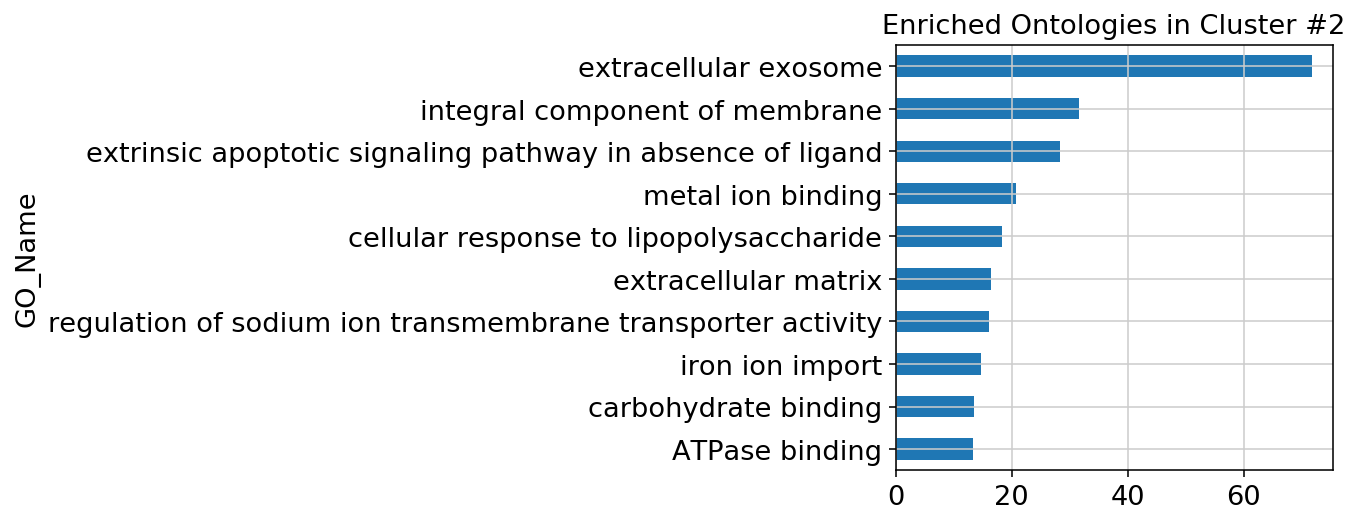


----------------------------------------------------------------------------------------------------

Plotting top 10 gene ontologies in cluster #7 using the top 100 genes
Missing annotations for 10 of 100 genes


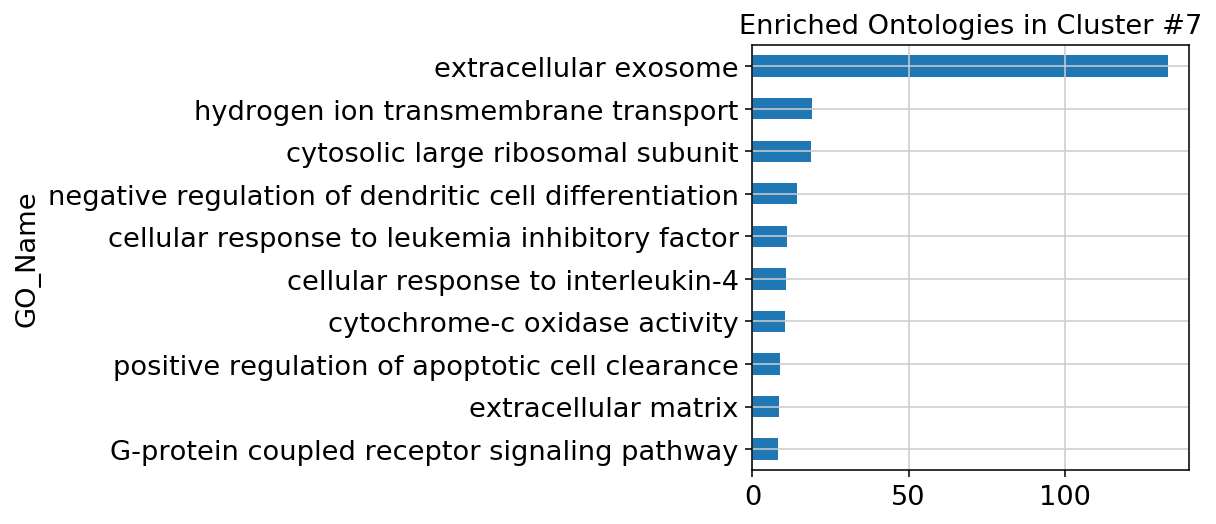


----------------------------------------------------------------------------------------------------



In [28]:
_ = [top_clust_ontologies(x, 10, 100) for x in [0, 1, 9, 2, 7]]

In [29]:
pop = arab_funcs.keys()

assoc = {}
for x in arab_funcs:
    name = arab_funcs[x]["DB_Object_Symbol"]
    if name not in assoc:
        assoc[name] = set()
    assoc[name].add(str(arab_funcs[x]['GO_ID']))

pop = assoc.keys()

In [30]:
methods = ['fdr_bh']
g = GOEnrichmentStudy(pop, assoc, go_db,
                         propagate_counts=False,
                         alpha=0.05,
                         methods=methods)

fisher module not installed.  Falling back on scipy.stats.fisher_exact
21,664 out of 21,664 population items found in association


In [31]:
def goatools_clust_ontologies(clust_num, top_n=200, pval=.01):
    print("Plotting top "+str(top_n)+" gene ontologies in cluster #"+str(clust_num))
    go_frame = pd.DataFrame([diff_genes.iloc[:, clust_num], diff_genes_scores.iloc[:, clust_num]]).T
    go_frame.columns = ["GeneName", "GeneScore"]
    go_frame = go_frame.merge(gene_frame[["DB_Object_Symbol", "GO_ID"]], how="left", left_on="GeneName", left_index=True, right_on="DB_Object_Symbol")
    study_out = g.run_study(np.array(diff_genes.iloc[:top_n, clust_num]))
    print([(r.p_fdr_bh, r.name, r.GO)  for r in study_out if r.get_pvalue() < pval])
    #g.print_summary(study_out, min_ratio=None, pval=pval)
    sig_gene = [r for r in study_out if r.p_fdr_bh < pval]
    sig_gene_GO = [r.GO for r in study_out if r.p_fdr_bh < pval]
    #plot_results("write/"+data_folder+"clust_"+str(clust_num)+"__{NS}.png", sig_gene)
    plot_gos("write/"+data_folder+"clust_"+str(clust_num)+".png", 
        sig_gene_GO, # Source GO ids
        go_db,
        goea_results=study_out, # use pvals for coloring
        # We can further configure the plot...
        study_items=6, # Only only 6 gene Symbols max on GO terms
        items_p_line=3, # Print 3 genes per line
    )
    print("\n"+"-"*100+"\n")
    return study_out

In [32]:
_ = [goatools_clust_ontologies(x, 400, .01) for x in [0, 1, 9, 2, 7]]

Plotting top 400 gene ontologies in cluster #0
Calculating uncorrected p-values using fisher_scipy_stats
   365 out of    400 study items found in association
Running multitest correction: statsmodels fdr_bh
  216 GO terms are associated with 365 of 400 study items
  4,609 GO terms are associated with 21,664 of 21,664 population items
[(5.6585168051040783e-06, 'detection of chemical stimulus involved in sensory perception of smell', 'GO:0050911'), (0.00036446632723739471, 'biological_process', 'GO:0008150'), (2.1681530791434349e-05, 'integral component of membrane', 'GO:0016021'), (0.00234040757373729, 'extracellular exosome', 'GO:0070062'), (0.00036446632723739471, 'proton-transporting ATP synthase activity, rotational mechanism', 'GO:0046933'), (0.0047997168591808201, '5.8S rRNA binding', 'GO:1990932')]
    6 usr  54 GOs  WROTE: write/data/progression/clust_0.png

----------------------------------------------------------------------------------------------------

Plotting top 400 ge